In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re, string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

In [ ]:
df=pd.read_csv('dialogs.txt',sep='\t',names=['question','answer'])
print(f'Dataframe size: {len(df)}')
df.head()

Dataframe size: 3725


,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


Data Preprocessing

Data Visualization

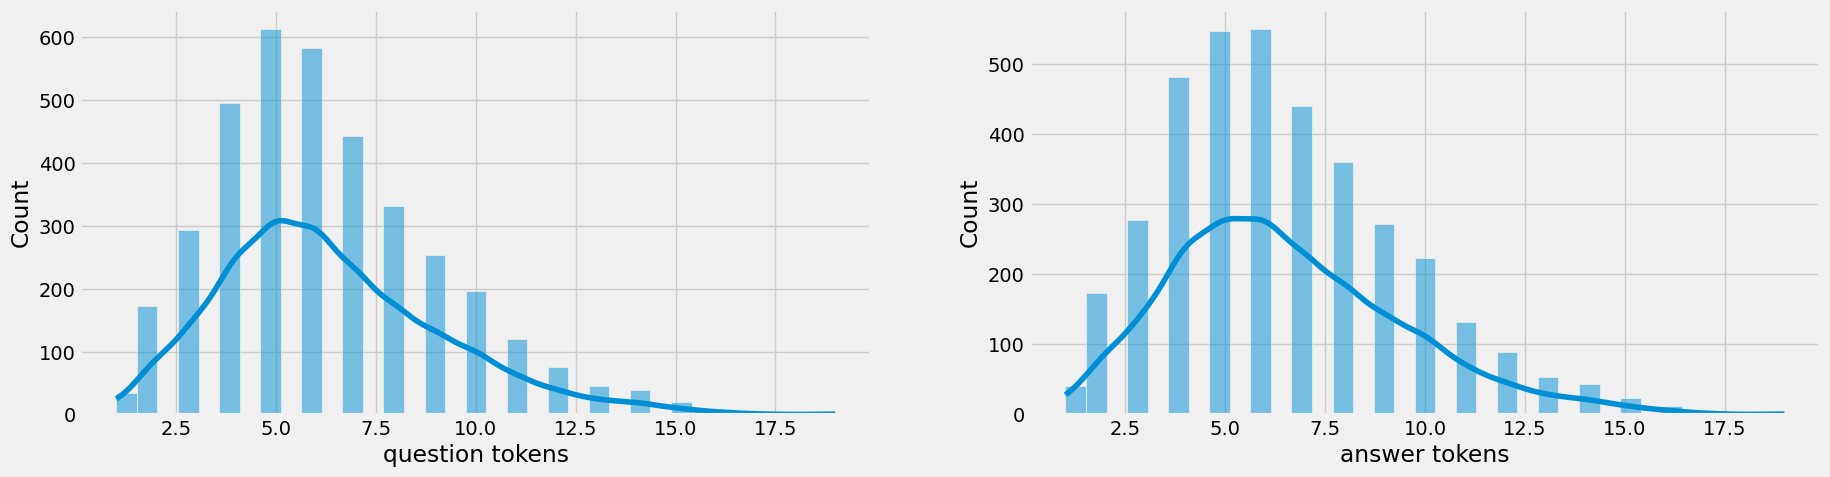

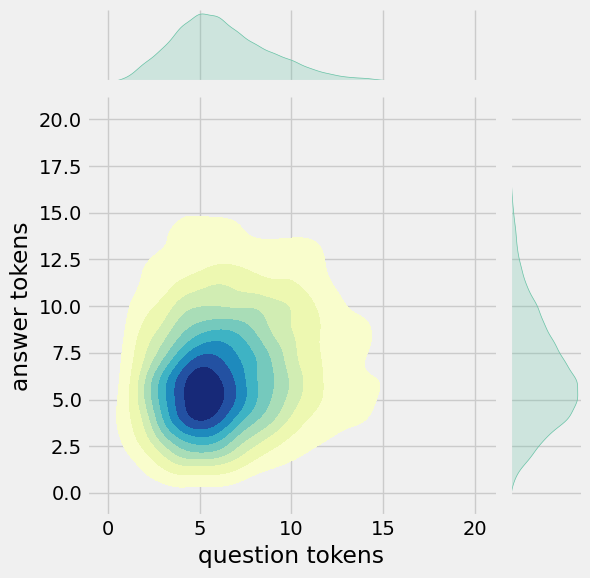

In [ ]:
df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['answer tokens']=df['answer'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['question tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['answer tokens'],data=df,kde=True,ax=ax[1])
sns.jointplot(x='question tokens',y='answer tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

Text Cleaning



In [ ]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

df.drop(columns=['answer tokens','question tokens'],axis=1,inplace=True)
df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['answer'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['answer'].apply(clean_text)+' <end>'

df.head(10)

,question,answer,encoder_inputs,decoder_targets,decoder_inputs
0,"hi, how are you doing?",i'm fine. how about yourself?,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem. so how have you been?,i've been great. what about you?,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i've been great. what about you?,i've been good. i'm in school right now.,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i've been good. i'm in school right now.,what school do you go to?,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to?,i go to pcc.,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc.,do you like it there?,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there?,it's okay. it's a really big campus.,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it's okay. it's a really big campus.,good luck with school.,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


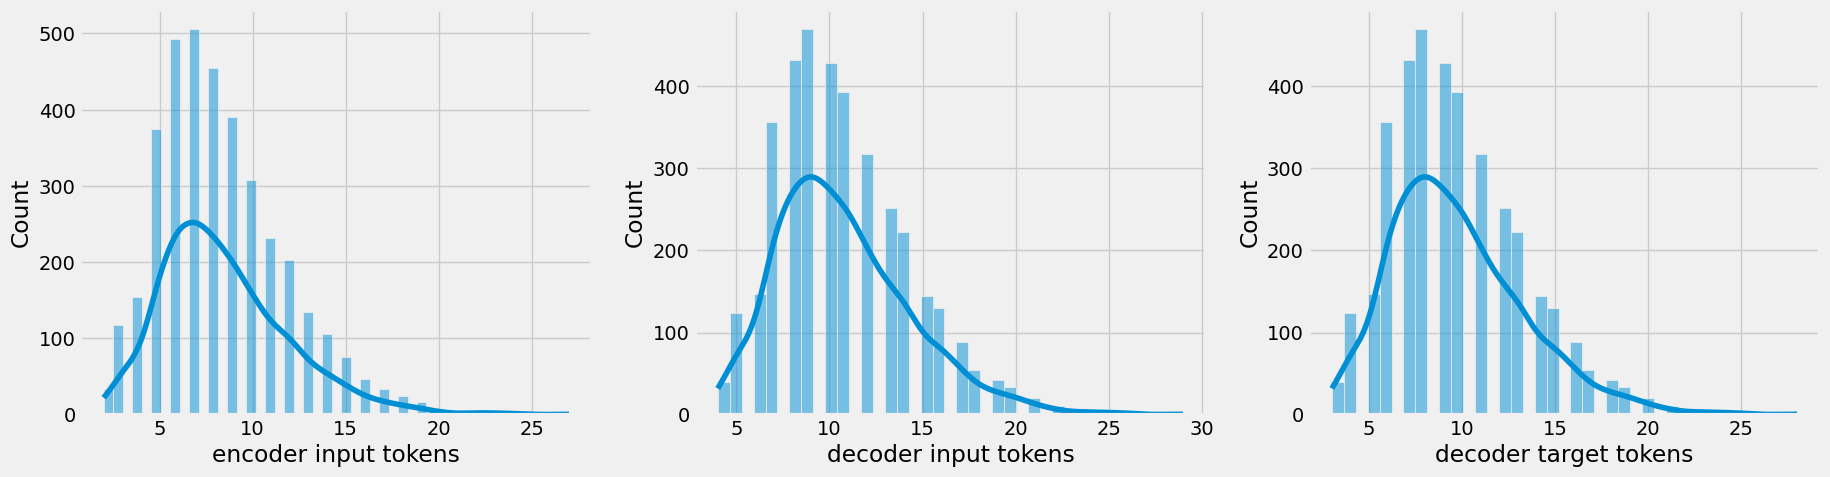

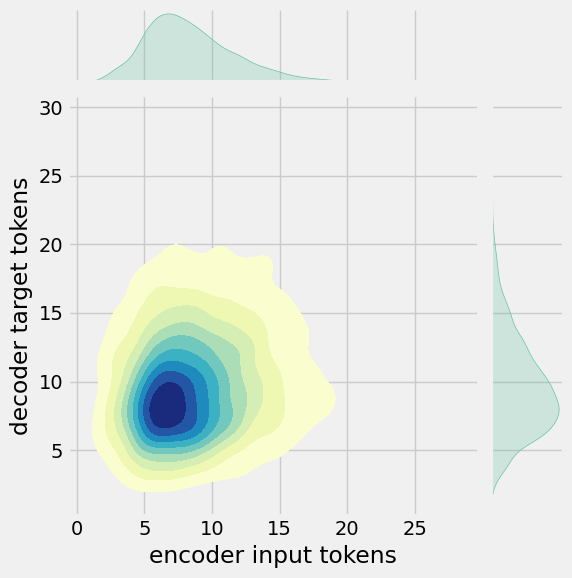

In [ ]:
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['encoder input tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['decoder input tokens'],data=df,kde=True,ax=ax[1])
sns.histplot(x=df['decoder target tokens'],data=df,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [ ]:
print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")
print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")

df.drop(columns=['question','answer','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']
df.head(10)

After preprocessing: for example ,  if your birth date is january  1  2  ,   1  9  8  7  ,  write  0  1  /  1  2  /  8  7  . 
Max encoder input length: 27
Max decoder input length: 29
Max decoder target length: 28


,encoder_inputs,decoder_targets,decoder_inputs
0,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


Tokenization

In [ ]:
vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')
vocab_size=len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 2443
['', '[UNK]', '<end>', '.', '<start>', "'", 'i', '?', 'you', ',', 'the', 'to']


In [ ]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: hi , how are you ?')
print(f'Question to tokens: {sequences2ids("hi , how are you ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: hi , how are you ?
Question to tokens: [1971    9   45   24    8    7    0    0    0    0]
Encoder input shape: (3725, 30)
Decoder input shape: (3725, 30)
Decoder target shape: (3725, 30)


In [ ]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [1971    9   45   24    8  194    7    0    0    0    0    0] ...
Decoder input: [  4   6   5  38 646   3  45  41 563   7   2   0] ...
Decoder target: [  6   5  38 646   3  45  41 563   7   2   0   0] ...


In [ ]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 23
Number of training data: 3427
Number of validation batches: 3
Number of validation data: 447
Encoder Input shape (with batches): (149, 30)
Decoder Input shape (with batches): (149, 30)
Target Output shape (with batches): (149, 30)


**Build Models**

Build Encoder

In [ ]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )

    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.23306406,  0.13272385,  0.18114215, ..., -0.13084537,
         -0.01558005, -0.1019468 ],
        [-0.03776644,  0.07558786,  0.10284121, ..., -0.14938532,
          0.06825898, -0.24904825],
        [ 0.1484703 , -0.01862016, -0.0338559 , ..., -0.04698755,
          0.02366681, -0.0699274 ],
        ...,
        [ 0.06263372, -0.0238117 , -0.01911898, ...,  0.01953427,
         -0.12553556, -0.14376539],
        [ 0.11393099,  0.20823258, -0.16088276, ...,  0.02322587,
          0.21025285, -0.0829823 ],
        [-0.14804974,  0.00139924,  0.15703294, ..., -0.16080083,
         -0.00800404,  0.04027252]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.45413607,  0.25483587,  0.31049186, ..., -0.31236458,
         -0.02302076, -0.18374565],
        [-0.06789288,  0.13998486,  0.17812817, ..., -0.32629982,
          0.1078082 , -0.488711  ],
        [ 0.26108637, -0.03528639, -0.05568434,

Build Decoder

In [ ]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )

    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 2443), dtype=float32, numpy=
array([[[3.4968165e-05, 1.3864733e-04, 3.1939955e-04, ...,
         5.8276253e-04, 1.1290829e-04, 1.7124177e-04],
        [1.6268234e-05, 6.2251456e-05, 9.1903523e-04, ...,
         9.3986193e-05, 7.2604082e-05, 4.2716143e-05],
        [1.8377298e-04, 4.0005840e-04, 8.5215899e-04, ...,
         1.5585741e-03, 3.6333079e-04, 4.1180097e-05],
        ...,
        [3.5561367e-05, 1.6151785e-04, 3.6802140e-04, ...,
         3.3375705e-04, 3.4765762e-05, 7.2106061e-04],
        [3.5561367e-05, 1.6151785e-04, 3.6802140e-04, ...,
         3.3375705e-04, 3.4765762e-05, 7.2106061e-04],
        [3.5561367e-05, 1.6151785e-04, 3.6802140e-04, ...,
         3.3375705e-04, 3.4765762e-05, 7.2106061e-04]]], dtype=float32)>

Build Training Model

In [ ]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)

    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics

    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

In [ ]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 30, 2443), dtype=float32, numpy=
array([[[3.49681359e-05, 1.38647316e-04, 3.19399522e-04, ...,
         5.82762237e-04, 1.12908288e-04, 1.71241772e-04],
        [1.62682427e-05, 6.22514563e-05, 9.19036102e-04, ...,
         9.39862366e-05, 7.26040817e-05, 4.27161613e-05],
        [1.83773183e-04, 4.00058052e-04, 8.52159515e-04, ...,
         1.55857403e-03, 3.63330822e-04, 4.11801193e-05],
        ...,
        [3.55613520e-05, 1.61517790e-04, 3.68021487e-04, ...,
         3.33757052e-04, 3.47657624e-05, 7.21060787e-04],
        [3.55613520e-05, 1.61517790e-04, 3.68021487e-04, ...,
         3.33757052e-04, 3.47657624e-05, 7.21060787e-04],
        [3.55613520e-05, 1.61517790e-04, 3.68021487e-04, ...,
         3.33757052e-04, 3.47657624e-05, 7.21060787e-04]],

       [[2.02815936e-05, 1.02087401e-03, 2.06348908e-04, ...,
         1.64725282e-03, 1.02237296e-04, 8.58777144e-04],
        [3.49836264e-05, 2.70427408e-04, 1.48384293e-04, ...,
         1.41345285e-04, 2

Train Model

In [ ]:
history=model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 1.6595 - accuracy: 0.2238
Epoch 1: val_loss improved from inf to 1.22428, saving model to ckpt


23/23 [==============================] - 99s 4s/step - loss: 1.6528 - accuracy: 0.2261 - val_loss: 1.2243 - val_accuracy: 0.2915
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 1.2336 - accuracy: 0.3120
Epoch 2: val_loss improved from 1.22428 to 1.19334, saving model to ckpt


23/23 [==============================] - 67s 3s/step - loss: 1.2332 - accuracy: 0.3123 - val_loss: 1.1933 - val_accuracy: 0.3275
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 1.1011 - accuracy: 0.3429
Epoch 3: val_loss improved from 1.19334 to 0.91129, saving model to ckpt


23/23 [==============================] - 65s 3s/step - loss: 1.0993 - accuracy: 0.3440 - val_loss: 0.9113 - val_accuracy: 0.3967
Epoch 4/100
23/23 [==============================] - ETA: 0s - loss: 1.0254 - accuracy: 0.3562
Epoch 4: val_loss did not improve from 0.91129
23/23 [==============================] - 43s 2s/step - loss: 1.0279 - accuracy: 0.3565 - val_loss: 0.9646 - val_accuracy: 0.3715
Epoch 5/100
23/23 [==============================] - ETA: 0s - loss: 0.9643 - accuracy: 0.3696
Epoch 5: val_loss did not improve from 0.91129
23/23 [==============================] - 47s 2s/step - loss: 0.9671 - accuracy: 0.3694 - val_loss: 0.9719 - val_accuracy: 0.3702
Epoch 6/100
23/23 [==============================] - ETA: 0s - loss: 0.9175 - accuracy: 0.3820
Epoch 6: val_loss improved from 0.91129 to 0.89733, saving model to ckpt


23/23 [==============================] - 68s 3s/step - loss: 0.9185 - accuracy: 0.3817 - val_loss: 0.8973 - val_accuracy: 0.3734
Epoch 7/100
23/23 [==============================] - ETA: 0s - loss: 0.8803 - accuracy: 0.3910
Epoch 7: val_loss improved from 0.89733 to 0.86960, saving model to ckpt


23/23 [==============================] - 67s 3s/step - loss: 0.8804 - accuracy: 0.3912 - val_loss: 0.8696 - val_accuracy: 0.3926
Epoch 8/100
23/23 [==============================] - ETA: 0s - loss: 0.8469 - accuracy: 0.4009
Epoch 8: val_loss improved from 0.86960 to 0.78755, saving model to ckpt


23/23 [==============================] - 68s 3s/step - loss: 0.8482 - accuracy: 0.4001 - val_loss: 0.7875 - val_accuracy: 0.4282
Epoch 9/100
23/23 [==============================] - ETA: 0s - loss: 0.8133 - accuracy: 0.4130
Epoch 9: val_loss did not improve from 0.78755
23/23 [==============================] - 43s 2s/step - loss: 0.8119 - accuracy: 0.4140 - val_loss: 0.8259 - val_accuracy: 0.4350
Epoch 10/100
23/23 [==============================] - ETA: 0s - loss: 0.7888 - accuracy: 0.4227
Epoch 10: val_loss did not improve from 0.78755
23/23 [==============================] - 44s 2s/step - loss: 0.7865 - accuracy: 0.4236 - val_loss: 0.7894 - val_accuracy: 0.4037
Epoch 11/100
23/23 [==============================] - ETA: 0s - loss: 0.7672 - accuracy: 0.4287
Epoch 11: val_loss improved from 0.78755 to 0.78366, saving model to ckpt


23/23 [==============================] - 66s 3s/step - loss: 0.7669 - accuracy: 0.4286 - val_loss: 0.7837 - val_accuracy: 0.4459
Epoch 12/100
23/23 [==============================] - ETA: 0s - loss: 0.7441 - accuracy: 0.4401
Epoch 12: val_loss did not improve from 0.78366
23/23 [==============================] - 42s 2s/step - loss: 0.7438 - accuracy: 0.4396 - val_loss: 0.8358 - val_accuracy: 0.4047
Epoch 13/100
23/23 [==============================] - ETA: 0s - loss: 0.7273 - accuracy: 0.4470
Epoch 13: val_loss improved from 0.78366 to 0.67640, saving model to ckpt


23/23 [==============================] - 65s 3s/step - loss: 0.7285 - accuracy: 0.4469 - val_loss: 0.6764 - val_accuracy: 0.4797
Epoch 14/100
23/23 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.4506
Epoch 14: val_loss did not improve from 0.67640
23/23 [==============================] - 44s 2s/step - loss: 0.7129 - accuracy: 0.4491 - val_loss: 0.7337 - val_accuracy: 0.4576
Epoch 15/100
23/23 [==============================] - ETA: 0s - loss: 0.6988 - accuracy: 0.4577
Epoch 15: val_loss did not improve from 0.67640
23/23 [==============================] - 44s 2s/step - loss: 0.7064 - accuracy: 0.4565 - val_loss: 0.7085 - val_accuracy: 0.4783
Epoch 16/100
23/23 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.4698
Epoch 16: val_loss did not improve from 0.67640
23/23 [==============================] - 49s 2s/step - loss: 0.6806 - accuracy: 0.4689 - val_loss: 0.7679 - val_accuracy: 0.4636
Epoch 17/100
23/23 [==============================] 

23/23 [==============================] - 67s 3s/step - loss: 0.6441 - accuracy: 0.4849 - val_loss: 0.6689 - val_accuracy: 0.4856
Epoch 20/100
23/23 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.4915
Epoch 20: val_loss did not improve from 0.66895
23/23 [==============================] - 44s 2s/step - loss: 0.6330 - accuracy: 0.4910 - val_loss: 0.6739 - val_accuracy: 0.4825
Epoch 21/100
23/23 [==============================] - ETA: 0s - loss: 0.6208 - accuracy: 0.4957
Epoch 21: val_loss improved from 0.66895 to 0.57702, saving model to ckpt


23/23 [==============================] - 66s 3s/step - loss: 0.6218 - accuracy: 0.4958 - val_loss: 0.5770 - val_accuracy: 0.5087
Epoch 22/100
23/23 [==============================] - ETA: 0s - loss: 0.6072 - accuracy: 0.5043
Epoch 22: val_loss did not improve from 0.57702
23/23 [==============================] - 46s 2s/step - loss: 0.6076 - accuracy: 0.5045 - val_loss: 0.6275 - val_accuracy: 0.5086
Epoch 23/100
23/23 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.5079
Epoch 23: val_loss did not improve from 0.57702
23/23 [==============================] - 46s 2s/step - loss: 0.6071 - accuracy: 0.5065 - val_loss: 0.6438 - val_accuracy: 0.5140
Epoch 24/100
23/23 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.5130
Epoch 24: val_loss did not improve from 0.57702
23/23 [==============================] - 44s 2s/step - loss: 0.5934 - accuracy: 0.5115 - val_loss: 0.7077 - val_accuracy: 0.4938
Epoch 25/100
23/23 [==============================] 

23/23 [==============================] - 68s 3s/step - loss: 0.5496 - accuracy: 0.5373 - val_loss: 0.5673 - val_accuracy: 0.5683
Epoch 31/100
23/23 [==============================] - ETA: 0s - loss: 0.5358 - accuracy: 0.5449
Epoch 31: val_loss improved from 0.56731 to 0.54500, saving model to ckpt


23/23 [==============================] - 72s 3s/step - loss: 0.5366 - accuracy: 0.5447 - val_loss: 0.5450 - val_accuracy: 0.5653
Epoch 32/100
23/23 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.5453
Epoch 32: val_loss improved from 0.54500 to 0.53962, saving model to ckpt


23/23 [==============================] - 66s 3s/step - loss: 0.5297 - accuracy: 0.5447 - val_loss: 0.5396 - val_accuracy: 0.5539
Epoch 33/100
23/23 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.5489
Epoch 33: val_loss did not improve from 0.53962
23/23 [==============================] - 46s 2s/step - loss: 0.5186 - accuracy: 0.5497 - val_loss: 0.6561 - val_accuracy: 0.5396
Epoch 34/100
23/23 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.5518
Epoch 34: val_loss did not improve from 0.53962
23/23 [==============================] - 44s 2s/step - loss: 0.5201 - accuracy: 0.5517 - val_loss: 0.5865 - val_accuracy: 0.5535
Epoch 35/100
23/23 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.5571
Epoch 35: val_loss did not improve from 0.53962
23/23 [==============================] - 44s 2s/step - loss: 0.5130 - accuracy: 0.5567 - val_loss: 0.6114 - val_accuracy: 0.5407
Epoch 36/100
23/23 [==============================] 

23/23 [==============================] - 66s 3s/step - loss: 0.4988 - accuracy: 0.5648 - val_loss: 0.5077 - val_accuracy: 0.5618
Epoch 38/100
23/23 [==============================] - ETA: 0s - loss: 0.4963 - accuracy: 0.5686
Epoch 38: val_loss did not improve from 0.50774
23/23 [==============================] - 46s 2s/step - loss: 0.4955 - accuracy: 0.5684 - val_loss: 0.5767 - val_accuracy: 0.5386
Epoch 39/100
23/23 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.5722
Epoch 39: val_loss did not improve from 0.50774
23/23 [==============================] - 44s 2s/step - loss: 0.4918 - accuracy: 0.5715 - val_loss: 0.5742 - val_accuracy: 0.5749
Epoch 40/100
23/23 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.5774
Epoch 40: val_loss did not improve from 0.50774
23/23 [==============================] - 44s 2s/step - loss: 0.4904 - accuracy: 0.5762 - val_loss: 0.5598 - val_accuracy: 0.5845
Epoch 41/100
23/23 [==============================] 

23/23 [==============================] - 67s 3s/step - loss: 0.4621 - accuracy: 0.5896 - val_loss: 0.4598 - val_accuracy: 0.5908
Epoch 47/100
23/23 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.5944
Epoch 47: val_loss did not improve from 0.45981
23/23 [==============================] - 44s 2s/step - loss: 0.4588 - accuracy: 0.5946 - val_loss: 0.6380 - val_accuracy: 0.5462
Epoch 48/100
23/23 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.5965
Epoch 48: val_loss did not improve from 0.45981
23/23 [==============================] - 44s 2s/step - loss: 0.4535 - accuracy: 0.5954 - val_loss: 0.5524 - val_accuracy: 0.5771
Epoch 49/100
23/23 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.6040
Epoch 49: val_loss did not improve from 0.45981
23/23 [==============================] - 44s 2s/step - loss: 0.4467 - accuracy: 0.6044 - val_loss: 0.4912 - val_accuracy: 0.5912
Epoch 50/100
23/23 [==============================] 

23/23 [==============================] - 66s 3s/step - loss: 0.4420 - accuracy: 0.6023 - val_loss: 0.4300 - val_accuracy: 0.6121
Epoch 52/100
23/23 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.6018
Epoch 52: val_loss did not improve from 0.42997
23/23 [==============================] - 43s 2s/step - loss: 0.4416 - accuracy: 0.6009 - val_loss: 0.4695 - val_accuracy: 0.5847
Epoch 53/100
23/23 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.6097
Epoch 53: val_loss did not improve from 0.42997
23/23 [==============================] - 44s 2s/step - loss: 0.4377 - accuracy: 0.6093 - val_loss: 0.6029 - val_accuracy: 0.5523
Epoch 54/100
23/23 [==============================] - ETA: 0s - loss: 0.4353 - accuracy: 0.6065
Epoch 54: val_loss did not improve from 0.42997
23/23 [==============================] - 44s 2s/step - loss: 0.4360 - accuracy: 0.6058 - val_loss: 0.5686 - val_accuracy: 0.5799
Epoch 55/100
23/23 [==============================] 

23/23 [==============================] - 69s 3s/step - loss: 0.4253 - accuracy: 0.6162 - val_loss: 0.4250 - val_accuracy: 0.6255
Epoch 57/100
23/23 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.6156
Epoch 57: val_loss did not improve from 0.42502
23/23 [==============================] - 44s 2s/step - loss: 0.4245 - accuracy: 0.6135 - val_loss: 0.5389 - val_accuracy: 0.5736
Epoch 58/100
23/23 [==============================] - ETA: 0s - loss: 0.4202 - accuracy: 0.6200
Epoch 58: val_loss did not improve from 0.42502
23/23 [==============================] - 44s 2s/step - loss: 0.4209 - accuracy: 0.6199 - val_loss: 0.4840 - val_accuracy: 0.6083
Epoch 59/100
23/23 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.6172
Epoch 59: val_loss did not improve from 0.42502
23/23 [==============================] - 44s 2s/step - loss: 0.4216 - accuracy: 0.6167 - val_loss: 0.4656 - val_accuracy: 0.5903
Epoch 60/100
23/23 [==============================] 

23/23 [==============================] - 67s 3s/step - loss: 0.3967 - accuracy: 0.6337 - val_loss: 0.4243 - val_accuracy: 0.6289
Epoch 68/100
23/23 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.6364
Epoch 68: val_loss did not improve from 0.42432
23/23 [==============================] - 47s 2s/step - loss: 0.3983 - accuracy: 0.6362 - val_loss: 0.5829 - val_accuracy: 0.6007
Epoch 69/100
23/23 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.6365
Epoch 69: val_loss improved from 0.42432 to 0.39573, saving model to ckpt


23/23 [==============================] - 67s 3s/step - loss: 0.3979 - accuracy: 0.6348 - val_loss: 0.3957 - val_accuracy: 0.6552
Epoch 70/100
23/23 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.6361
Epoch 70: val_loss did not improve from 0.39573
23/23 [==============================] - 43s 2s/step - loss: 0.3879 - accuracy: 0.6360 - val_loss: 0.5011 - val_accuracy: 0.6171
Epoch 71/100
23/23 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.6390
Epoch 71: val_loss did not improve from 0.39573
23/23 [==============================] - 44s 2s/step - loss: 0.3912 - accuracy: 0.6389 - val_loss: 0.4359 - val_accuracy: 0.6198
Epoch 72/100
23/23 [==============================] - ETA: 0s - loss: 0.3872 - accuracy: 0.6446
Epoch 72: val_loss did not improve from 0.39573
23/23 [==============================] - 45s 2s/step - loss: 0.3884 - accuracy: 0.6451 - val_loss: 0.5601 - val_accuracy: 0.6000
Epoch 73/100
23/23 [==============================] 

23/23 [==============================] - 68s 3s/step - loss: 0.3727 - accuracy: 0.6510 - val_loss: 0.3957 - val_accuracy: 0.6305
Epoch 80/100
23/23 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.6532
Epoch 80: val_loss did not improve from 0.39568
23/23 [==============================] - 45s 2s/step - loss: 0.3708 - accuracy: 0.6529 - val_loss: 0.4255 - val_accuracy: 0.6330
Epoch 81/100
23/23 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.6580
Epoch 81: val_loss did not improve from 0.39568
23/23 [==============================] - 44s 2s/step - loss: 0.3691 - accuracy: 0.6575 - val_loss: 0.4709 - val_accuracy: 0.6319
Epoch 82/100
23/23 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.6537
Epoch 82: val_loss improved from 0.39568 to 0.38144, saving model to ckpt


23/23 [==============================] - 67s 3s/step - loss: 0.3703 - accuracy: 0.6534 - val_loss: 0.3814 - val_accuracy: 0.6574
Epoch 83/100
23/23 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.6562
Epoch 83: val_loss did not improve from 0.38144
23/23 [==============================] - 47s 2s/step - loss: 0.3662 - accuracy: 0.6554 - val_loss: 0.4164 - val_accuracy: 0.6485
Epoch 84/100
23/23 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.6587
Epoch 84: val_loss did not improve from 0.38144
23/23 [==============================] - 44s 2s/step - loss: 0.3632 - accuracy: 0.6585 - val_loss: 0.5449 - val_accuracy: 0.6190
Epoch 85/100
23/23 [==============================] - ETA: 0s - loss: 0.3612 - accuracy: 0.6603
Epoch 85: val_loss did not improve from 0.38144
23/23 [==============================] - 44s 2s/step - loss: 0.3607 - accuracy: 0.6599 - val_loss: 0.4749 - val_accuracy: 0.6447
Epoch 86/100
23/23 [==============================] 

23/23 [==============================] - 67s 3s/step - loss: 0.3549 - accuracy: 0.6661 - val_loss: 0.3542 - val_accuracy: 0.6872
Epoch 91/100
23/23 [==============================] - ETA: 0s - loss: 0.3514 - accuracy: 0.6688
Epoch 91: val_loss did not improve from 0.35420
23/23 [==============================] - 45s 2s/step - loss: 0.3516 - accuracy: 0.6679 - val_loss: 0.4435 - val_accuracy: 0.6352
Epoch 92/100
23/23 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.6707
Epoch 92: val_loss did not improve from 0.35420
23/23 [==============================] - 44s 2s/step - loss: 0.3521 - accuracy: 0.6705 - val_loss: 0.5358 - val_accuracy: 0.6203
Epoch 93/100
23/23 [==============================] - ETA: 0s - loss: 0.3479 - accuracy: 0.6707
Epoch 93: val_loss did not improve from 0.35420
23/23 [==============================] - 42s 2s/step - loss: 0.3482 - accuracy: 0.6698 - val_loss: 0.4942 - val_accuracy: 0.6341
Epoch 94/100
23/23 [==============================] 

Visualize Metrics

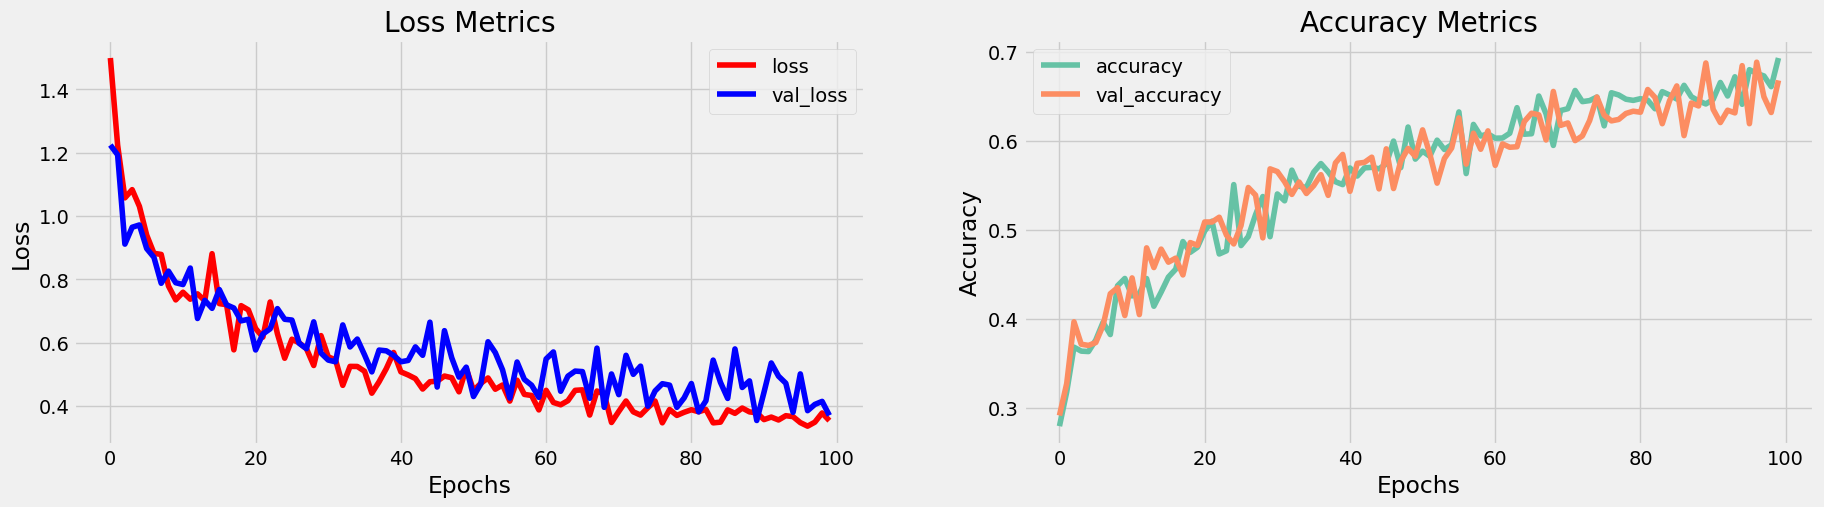

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

Save Model

In [ ]:
model.load_weights('ckpt')
model.save('models',save_format='tf')

In [ ]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


Create Inference Model

In [ ]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq

    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddi  (None, None, 256)         625408    
 ng)                                                             
                                                                 
 layer_normalization (Layer  (None, None, 256)         512       
 Normalization)                                                  
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1151232 (4.39 MB)
Trainable params: 1

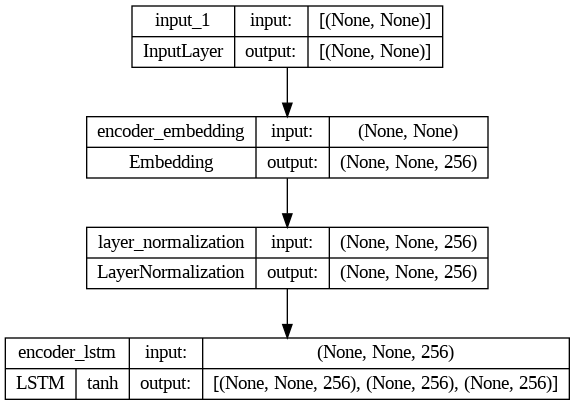

In [ ]:
tf.keras.utils.plot_model(chatbot.encoder,to_file='encoder.png',show_shapes=True,show_layer_activations=True)

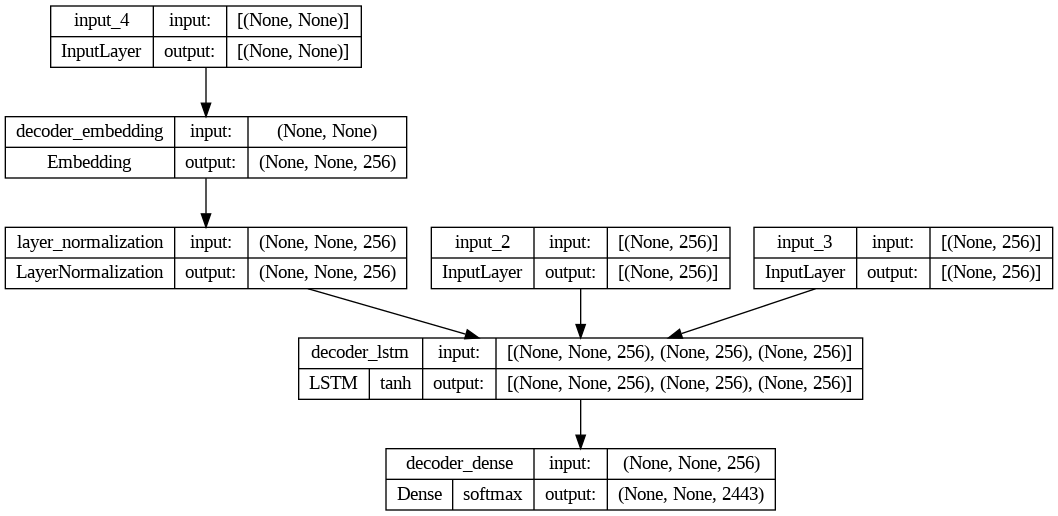

In [ ]:
tf.keras.utils.plot_model(chatbot.decoder,to_file='decoder.png',show_shapes=True,show_layer_activations=True)

Test case for bot to Chat

In [ ]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')
        print('========================')

In [ ]:
print_conversation([
    'hi',
    'do yo know me?',
    'what is your name?',
    'you are bot?',
    'hi, how are you doing?',
    "i'm pretty good. thanks for asking.",
    "Don't ever be in a hurry",
    '''I'm gonna put some dirt in your eye ''',
    '''You're trash ''',
    '''I've read all your research on nano-technology ''',
    '''You want forgiveness? Get religion''',
    '''While you're using the bathroom, i'll order some food.''',
    '''Wow! that's terrible.''',
    '''We'll be here forever.''',
    '''I need something that's reliable.''',
    '''A speeding car ran a red light, killing the girl.''',
    '''Tomorrow we'll have rice and fish for lunch.''',
    '''I like this restaurant because they give you free bread.'''
])

You: hi
Bot: ' s been good with you. 
You: do yo know me?
Bot: i think we'll be there. 
You: what is your name?
Bot: my family are30 0. 
You: you are bot?
Bot: yes, i do. 
You: hi, how are you doing?
Bot: i'm going to so far. i'm pretty good. 
You: i'm pretty good. thanks for asking.
Bot: no problem. i'm sure that i'll see you next time. 
You: Don't ever be in a hurry
Bot: it's the law. they're not going to do it. 
You: I'm gonna put some dirt in your eye 
Bot: you think you're a talented. 
You: You're trash 
Bot: i have to go a lot. 
You: I've read all your research on nano-technology 
Bot: is that right? you're not very much. 
You: You want forgiveness? Get religion
Bot: i'm sure. i think it's going to rain later. 
You: While you're using the bathroom, i'll order some food.
Bot: i have to get to a lot of coffee. what's the problem? 
You: Wow! that's terrible.
Bot: yes, it's too close to the salad bar. 
You: We'll be here forever.
Bot: we have to be there. 
You: I need something that'